In [1]:
import pulp
import networkx as nx

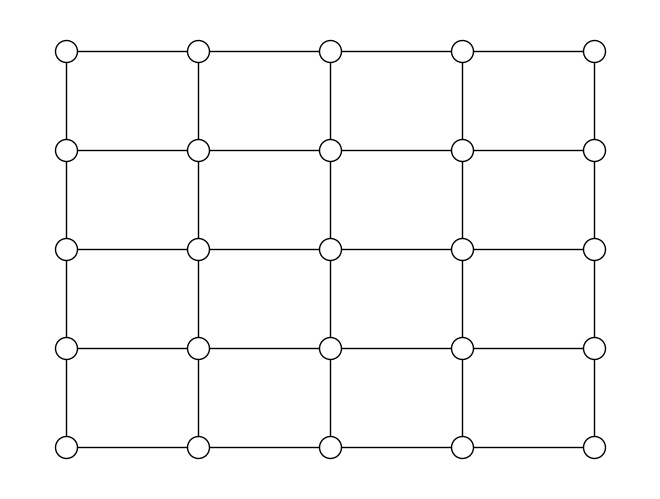

In [2]:
rows = 5
cols = 5
G = nx.grid_2d_graph(rows, cols)
for r in range(rows):
    for c in range(cols):
        G.nodes[(r, c)]["layer"] = c
nx.draw(G,pos=nx.multipartite_layout(G,subset_key="layer",align="vertical"),
        node_color="white",
        edgecolors="black",
        node_size=250)

In [3]:
P_TYPES = [
           "monomino",
           "domino",
           "I triomino",
           "L triomino",
           #"L3x6 octomino"
          ]
OFFSETS = [
([(0,0)],"monomino",1), # monomino
([(0,0),(0,1)],"domino",2), # vertical domino
([(0,0),(1,0)],"domino",3), # horizontal domino
([(0, 0),(0, 1),(0, 2)],"I triomino",4), # vertical triomino
([(0, 0),(1, 0),(2, 0)],"I triomino",5), # horizontal triomino
([(0, 0),(0, 1),(1, 1)],"L triomino",6), # L triomino id
([(0, 0), (1, 0), (0, 1)],"L triomino",7), # L triomino 90°
([(0, 0), (1, 0), (1, -1)],"L triomino",8), # L triomino 180°
([(0, 0), (0, -1), (-1, -1)],"L triomino",9), # L triomino 270°
#([(0, 0), (1, 0), (2, 0),(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)],"L3x6 octomino",10), # L octomino 1
#([(0, 0), (0, 1), (0, 2),(-1, 0), (-2, 0), (-3, 0), (-4, 0), (-5, 0)],"L3x6 octomino",11), # L octomino 2 ...
#([(0, 0), (-1, 0), (-2, 0),(0, -1), (0, -2), (0, -3), (0, -4), (0, -5)],"L3x6 octomino",12),
#([(0, 0), (0, -1), (0, -2),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)],"L3x6 octomino",13),
#([(0, 0), (-1, 0), (-2, 0),(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)],"L3x6 octomino",14),
#([(0, 0), (0, -1), (0, -2),(-1, 0), (-2, 0), (-3, 0), (-4, 0), (-5, 0)],"L3x6 octomino",15),
#([(0, 0), (1, 0), (2, 0),(0, -1), (0, -2), (0, -3), (0, -4), (0, -5)],"L3x6 octomino",16),
#([(0, 0), (0, 1), (0, 2),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)],"L3x6 octomino",17),
]
COLORS = dict(zip([i for i in range(1,18)],[
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#2ca02c",  # green
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
    "#393b79",  # dark blue
    "#637939",  # olive
    "#8c6d31",  # ochre
    "#843c39",  # dark red
    "#7b4173",  # violet
    "#3182bd",  # bright blue
    "#31a354",  # bright green
]))

polyominoes = []
for node in G.nodes():
    x0, y0 = node
    for offset,name,id in OFFSETS:
        T = [(x0 + dx, y0 + dy) for (dx, dy) in offset]
        if all(G.has_node(v) for v in T): 
            P=G.subgraph(T).copy()
            P.graph["type"] = name
            P.graph["color"] = COLORS[id]
            polyominoes.append(P)
polyominoes_dict = dict(zip([i for i in range(len(polyominoes))],polyominoes))

In [4]:
# create problem
prob = pulp.LpProblem("touching_polyominoes", pulp.LpMinimize)

# x[p] = 1 pentamino p is used
x = pulp.LpVariable.dicts("x",polyominoes_dict,cat=pulp.LpBinary)

# dummy objective
prob+= 0 

# one polyomino of each type
for p_type in P_TYPES:
    prob+= pulp.lpSum(x[p] for p in polyominoes_dict if polyominoes_dict[p].graph["type"]==p_type) == 1

# no overlap
for (r,c) in G.nodes():
    prob+= pulp.lpSum(x[p] for p in polyominoes_dict if (r,c) in polyominoes_dict[p].nodes()) <= 1

# two non adjacent polyominoes cannot be selected simultaneously
for p in polyominoes_dict:
    for q in polyominoes_dict:
        if p!=q:
            P = polyominoes_dict[p]
            Q = polyominoes_dict[q]
            boundary_p = nx.node_boundary(G, P)
            if boundary_p.isdisjoint(Q):
                prob+= x[p]+x[q] <= 1

# optional constraints to center the resulting configuration in the middle
prob += pulp.lpSum(x[p] for p in polyominoes_dict if (1,1) in polyominoes_dict[p].nodes()) == 1
prob += pulp.lpSum(x[p] for p in polyominoes_dict if (3,3) in polyominoes_dict[p].nodes()) == 1

In [5]:
prob.solve()

1

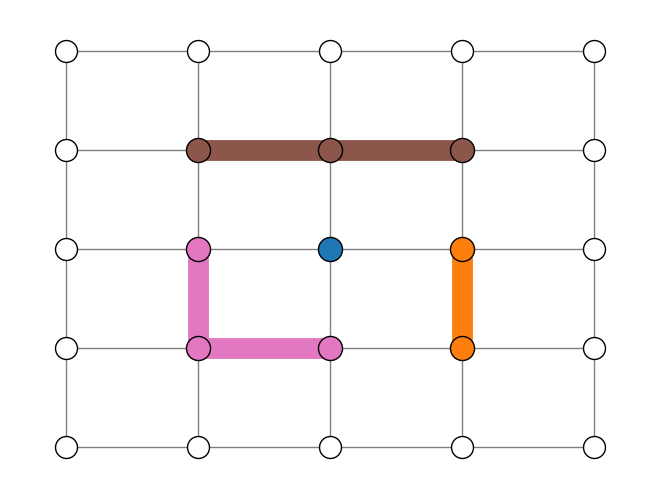

In [6]:
pos = {(x, y): (x,-y) for x, y in G.nodes()} 
nx.draw(G, pos, node_size=250, node_color="white",
                edgecolors="black",edge_color='grey')
for p in x:
    if pulp.value(x[p])>0.9:
        P = polyominoes_dict[p]
        nx.draw(P, pos, 
                node_color=P.graph["color"],
                edgecolors="black",
                edge_color=P.graph["color"],
                width=15)